In [1]:
%matplotlib inline

In [115]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.ned import Ned

Create a simple template WCS approximating that of Huntsman. Doing it manually here, but could instead just extract one from the headers of an astrometrically calibrated Huntsman Eye FITS file.

In [165]:
# SBIG STF-8300M resolution
n_pix_x = 3326
n_pix_y = 2504

# 2 dimensional WCS; simple RA, dec tangent plane projection (should be right to within a percent or so)
huntsman_wcs = WCS(naxis=2)
huntsman_wcs.wcs.ctype = ['RA---TAN', 'DEC--TAN']

# CCD resolution
huntsman_wcs._naxis1 = n_pix_x
huntsman_wcs._naxis2 = n_pix_y

# Make centre of CCD the WCS reference poiunt
huntsman_wcs.wcs.crpix = (n_pix_x/2, n_pix_y/2)

# Approximate x, y pixel scale for Canon 2.8/400 + STF-8300M
huntsman_wcs.wcs.cdelt = ((-2.84, 2.84) * u.arcsecond).to(u.degree)

Check WCS by converting to FITS header format

In [166]:
huntsman_wcs.to_header()

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               1663.0 / Pixel coordinate of reference point            
CRPIX2  =               1252.0 / Pixel coordinate of reference point            
CDELT1  = -0.00078888888888889 / [deg] Coordinate increment at reference point  
CDELT2  =  0.00078888888888889 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               
CRVAL1  =                  0.0 / [deg] Coordinate value at reference point      
CRVAL2  =                  0.0 / [deg] Coordinate value at reference point      
LONPOLE =                180.0 / [deg] Native longitude of celestial pole       
LATPOLE =                  0

Random field centre, close to the SCP.

In [167]:
field_centre = SkyCoord("4h23m15s -85d12m31.2s")

In [168]:
field_centre

<SkyCoord (ICRS): (ra, dec) in deg
    ( 65.8125, -85.20866667)>

Set WCS reference coordinates to field centre coordinates

In [169]:
huntsman_wcs.wcs.crval = [field_centre.ra.value, field_centre.dec.value]

Can directly calculate the RA, dec coordinates (in degrees) of the corners of the field of view.

In [170]:
huntsman_wcs.calc_footprint()

array([[ 84.83804573, -85.97633365],
       [ 78.61461647, -84.07479132],
       [ 53.00293474, -84.07461747],
       [ 46.77633068, -85.97607715]])

For a rigourous check of whether an astronomical object is within the field of view or not can calculate its position on the CCD in pixel coordinates and check it's within the bounds of the CCD.

For an example fetch a set of 42 (!) low redshift objects from NED

In [ ]:
galaxies = Ned.query_region(field_centre, radius = 100 * u.arcminute)

In [189]:
# Filter to select only galaxies with a redshift, and only between 0 and 0.2
def redshift_filter(table, key_colnames):
    if np.any(table['Redshift'] > 0) and np.any(table['Redshift'] < 0.2):
        return True
    else:
        return False

In [188]:
galaxies_grouped = galaxies.group_by(('No.', 'Object Name'))
filtered_galaxies = galaxies_grouped.groups.filter(redshift_filter)
filtered_galaxies['RA(deg)'].unit = u.degree
filtered_galaxies['DEC(deg)'].unit = u.degree
len(filtered_galaxies)

Now filter again based on pixel coordinates. First use WCS to convert RA, dec of galaxies to pixel coordinates on the CCD

In [191]:
filtered_galaxies_pixels = huntsman_wcs.all_world2pix(np.array((filtered_galaxies['RA(deg)'], filtered_galaxies['DEC(deg)'])).T, 0)

Then check which pairs of pixel coordinate actually fall within the CCD.

In [216]:
# Filter to check is pixel coordinates are withing
def pixels_in_fov(coords):
    x_check = np.logical_and(coords[:,0] > 0, coords[:,0] < n_pix_x)
    y_check = np.logical_and(coords[:,1] > 0, coords[:,1] < n_pix_y)
    return np.logical_and(x_check, y_check)

In [222]:
good_galaxies = filtered_galaxies_pixels[np.where(pixels_in_fov(filtered_galaxies_pixels))]
bad_galaxies = filtered_galaxies_pixels[np.where(np.logical_not(pixels_in_fov(filtered_galaxies_pixels)))]

Finally produce a plot illustrating the results using the WCSAxes functionality integrated into astropy 1.3 (http://docs.astropy.org/en/stable/visualization/wcsaxes/index.html)

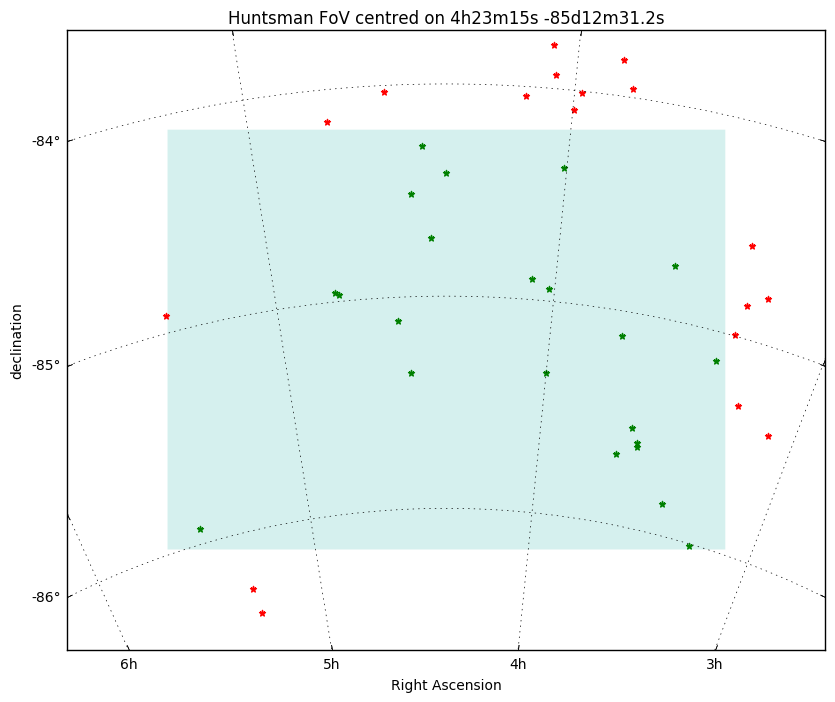

In [234]:
ax = plt.subplot(projection=huntsman_wcs)
# A dummy data array to highlight the Huntsman FoV
ax.imshow(np.ones((n_pix_y, n_pix_x)), cmap='cubehelix', vmin=0, vmax=1.1)
# Overlay coordinate grids in world coordinates (RA, dec)
ax.grid()
# Plot positions of galaxies. Plotting commands operate in pixel coordinates
# by default but can plot using RA, dec by using transform=ax.get_transform('world')
ax.scatter(good_galaxies.T[0], good_galaxies.T[1], marker='*', color='g')
ax.scatter(bad_galaxies.T[0], bad_galaxies.T[1], marker='*', color='r')
plt.xlim(-600,n_pix_x+600)
plt.ylim(-600,n_pix_y+600)
ax.coords[0].set_axislabel('Right Ascension')
ax.coords[0].set_major_formatter('hh')
ax.coords[1].set_axislabel('declination')
ax.coords[1].set_major_formatter('dd')
plt.title('Huntsman FoV centred on 4h23m15s -85d12m31.2s')
plt.gcf().set_size_inches(12,8)
plt.savefig('huntsman_fov.png')